### Imports

In [100]:
from time import strftime
from keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
import keras
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, Add, Conv2D, Flatten, MaxPooling2D, AveragePooling2D
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import pydot
import graphviz
from keras.utils import plot_model

## Data generators
* define image size, 50 seem to work fine
* define batch size for which images will be read from the folder
* define training and validation data location, `proccesse_data` has all images, `proccessed_data_equal_number_of_sam` has equal amount of male and female data points (makes baseline accuracy 0.5, datapoints were discarded randomly)

In [101]:
img_width = 50
img_height = 50

batch_size = 32

# train_data_dir = './proccessed_data/gender/'
train_data_dir = './proccessed_data_equal_number_of_sam/gender/train/'
valid_data_dir = './proccessed_data_equal_number_of_sam/gender/validate/'

In [102]:
train_datagen = ImageDataGenerator(rescale=1.0/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    color_mode='grayscale',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
#     save_to_dir='./transformed_images'

Found 17512 images belonging to 2 classes.


In [103]:
valid_datagen = ImageDataGenerator(rescale=1.0/255)
valid_generator = valid_datagen.flow_from_directory(
    valid_data_dir,
    color_mode='grayscale',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


Found 1944 images belonging to 2 classes.


In [104]:
num_samples=train_generator.samples
num_classes=train_generator.num_classes
num_men = sum(train_generator.classes ==1)
num_woman = sum(train_generator.classes ==0)
print("num woman:", num_woman)
print("num men:", num_men)

num woman: 8756
num men: 8756


In [105]:
num_valid=valid_generator.samples
print("number of validation samples:", num_valid)

number of validation samples: 1944


## Define model hyper parameters:
Model has stages, each stage with different number of Residual Layers, and different number of filters per layer.
#### Define:
* number of filters per stage.
* number of residual layers per stage, each layer has one residual connection and two (BatchNorm) -> (ReLu) -> (BatchNorm) -> (Relu) -> (Conv2D)
* define how many FC layers and their size
* define dropout rate

In [106]:
# Number of network stages, each stage with different number of filters
stage_filters = [16, 32]

# depth of each stage
stage_depth = [2, 3]

assert len(stage_filters) == len(stage_depth)

num_stages = len(stage_filters)
dense_depth = 1
dense_size = 256

drop_prob = 0.3

## Define Network

In [107]:
inputs = Input(shape=train_generator.image_shape)

x = BatchNormalization()(inputs)
x = Activation('relu')(x)
x = Conv2D(filters=stage_filters[0], kernel_size=7)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(filters=stage_filters[0], kernel_size=7)(x)

x = MaxPooling2D(pool_size=(2, 2), strides=None)(x)

for stage in range(num_stages):
    filters = stage_filters[stage]
    depth = stage_depth[stage]
    # change residual from previouse stage to current size
    if 0 < stage: 
        # FIXME: does the 1x1 conv on the main branch, need to check if doing it only on residual is better
        x = Conv2D(filters=filters, kernel_size=(1, 1))(x) 
    for _ in range(depth-1):
        res = x
        # First resnet layer
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters=filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters=filters, kernel_size=3, padding='same')(x)
        
        # Second resnet layer
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters=filters, kernel_size=3, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters=filters, kernel_size=3, padding='same')(x)
        x = Add()([x, res])
        
        x = Dropout(drop_prob)(x)
    
        
x = AveragePooling2D(pool_size=(2, 2), strides=None)(x)
x = Flatten()(x)

for _ in range(dense_depth):
    x = Dense(dense_size, activation='relu')(x)
    
predictions = Dense(1, activation='sigmoid')(x)

In [108]:
model = Model(inputs=inputs, outputs=predictions)

### Compile

In [109]:
model.compile(optimizer='adam',
              loss='binary_crossentropy', metrics=['accuracy'])

### Load weights (if resuming a train)
Commented out for convinience

In [110]:
model.load_weights('./weights/Sat_07_Apr_2018_18_37_08.hdf5')

# Train
* define number of epochs
* define callbacks: 
    * `checkpointer` saves the weights after each epoch, iff validation loss went down.
    * `reduce_lr` reduces learning rate if validation loss plareus.

In [99]:
epochs = 20

In [111]:
checkpointer = ModelCheckpoint(filepath='./weights/{}.hdf5'.format(strftime("%a_%d_%b_%Y_%H_%M_%S")), verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0000001, verbose=1)
# tensorboard = TensorBoard(log_dir="./logs/{}".format(strftime("%a, %d %b %Y %H:%M:%S")))
sms_alert = DoneAlert()
callbacks = [reduce_lr, checkpointer, sms_alert]

history = model.fit_generator(train_generator,
                              validation_data=valid_generator,
                              validation_steps=num_valid//batch_size,
                              steps_per_epoch=num_samples//batch_size, 
                              epochs=epochs,
                              callbacks=callbacks,
                              verbose=1,
                              use_multiprocessing=True,
                              workers=4)

Epoch 1/20
547/547 [==============================] - 447s 818ms/step - loss: 0.2673 - acc: 0.8876 - val_loss: 0.3243 - val_acc: 0.8677

Epoch 00001: val_loss improved from inf to 0.32427, saving model to ./weights/Sat_07_Apr_2018_20_53_48.hdf5
Epoch 2/20
547/547 [==============================] - 429s 784ms/step - loss: 0.2657 - acc: 0.8876 - val_loss: 0.4469 - val_acc: 0.7870

Epoch 00002: val_loss did not improve
Epoch 3/20
547/547 [==============================] - 428s 783ms/step - loss: 0.2603 - acc: 0.8933 - val_loss: 0.3841 - val_acc: 0.8354

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 00003: val_loss did not improve
Epoch 4/20
547/547 [==============================] - 428s 783ms/step - loss: 0.2287 - acc: 0.9032 - val_loss: 0.2670 - val_acc: 0.8958

Epoch 00004: val_loss improved from 0.32427 to 0.26699, saving model to ./weights/Sat_07_Apr_2018_20_53_48.hdf5
Epoch 5/20
547/547 [==============================] - 425s 777ms/step - lo

## Visualize model 
(writes to file)

In [85]:
plot_model(model, to_file='model.png', show_shapes=True)

# screwing around area
playing with SMS alerts for training milestones (WILL SEND SMS TO ANDREY).

Can change `account_sid`, `auth_token`, `to` and `from` to info from a FREE twilio account (super easy to set up give you ~2k free sms)

In [161]:
from twilio.rest import Client


class DoneAlert(keras.callbacks.Callback):
    def on_train_end(self, logs={}):
        account_sid = "ACdb60c905cd24f1bd71e6b49efb7a75c4"
        auth_token = "607eb22c4134ad6904ce2ad87d066e58"
        client = Client(account_sid, auth_token)
        
        max_val_acc = max(self.model.history.history['val_acc'])
        min_val_loss = min(model.history.history['val_loss'])
        msg = "Training Ended. val_acc="+str(max_val_acc)+' \n min val_loss=' + str(min_val_loss)
        message = client.messages.create(to="+19258587735", from_="+16504828933 ", body=msg)

In [162]:
min(model.history.history['val_loss'])

0.25597581019004184

In [121]:
val_loss, val_acc, loss, acc, lr = model.history.history.values()

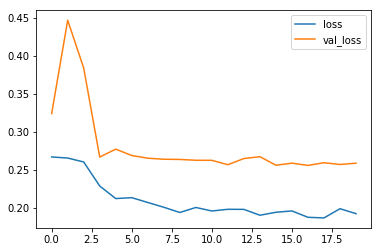

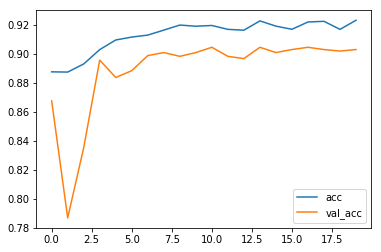

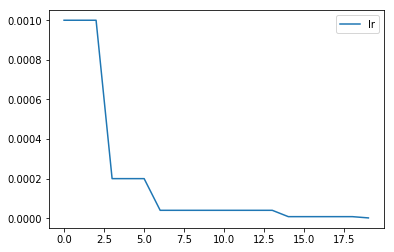

In [136]:
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()
plt.plot(acc, label="acc")
plt.plot(val_acc, label="val_acc")
plt.legend()
plt.show()
plt.plot(lr, label="lr")
plt.legend()
plt.show()